<a href="https://colab.research.google.com/github/VasudevPareek7/1brc/blob/main/VGG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [60]:
import torch
import torchvision
import torchvision.transforms as transforms

In [61]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 32

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


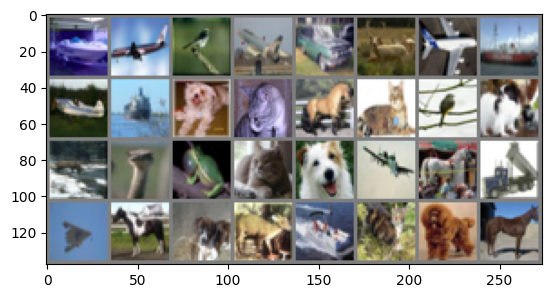

ship  plane bird  plane car   deer  plane ship  plane ship  dog   cat   horse cat   bird  dog   deer  bird  frog  cat   dog   plane horse truck plane horse dog   deer  ship  cat   dog   horse


In [62]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [63]:
import torch.nn as nn
import torch.nn.functional as F


In [71]:
class VGG11(nn.Module):
    def __init__(self):
        super().__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv4 = nn.Conv2d(256, 256, 3, padding=1)
        self.conv5 = nn.Conv2d(256, 512, 3, padding=1)
        self.conv6 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv7 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv8 = nn.Conv2d(512, 512, 3, padding=1)

        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(2)
        self.dropout = nn.Dropout(0.5)

        # Reduce number of FC nodes since we have larger feature maps now
        self.fc1 = nn.Linear(512 * 8 * 8, 4096)  # Changed input size
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 10)

    def forward(self, x):
        # Block 1
        x = self.relu(self.conv1(x))
        x = self.maxpool(x)  # 32->16

        # Block 2
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.maxpool(x)

        # Block 4 & 5 (removed maxpool layers)
        x = self.relu(self.conv5(x))
        x = self.relu(self.conv6(x))
        x = self.relu(self.conv7(x))
        x = self.relu(self.conv8(x))

        x = x.view(x.size(0), -1)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.fc3(x)

        return x

In [72]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [73]:
model = VGG11().to(device)
model

VGG11(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv8): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=32768, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=4096, bias=True)
  (fc3): Linear(in_features=4096, out_features=10, bias=True)
)

In [74]:
criterion = nn.CrossEntropyLoss()

In [75]:
import torch.optim as optim
optimiser = optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9, weight_decay= 5e-4)

In [76]:
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimiser, 'min', patience = 3, factor = 0.1)

In [ ]:


# Training function
def train_epoch(model, trainloader, criterion, optimiser, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for i, (inputs, labels) in enumerate(trainloader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimiser.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimiser.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        if (i + 1) % 100 == 0:
            print(f'Batch [{i+1}/{len(trainloader)}], '
                  f'Loss: {running_loss/100:.3f}, '
                  f'Acc: {100.*correct/total:.2f}%')
            running_loss = 0.0

    return running_loss/len(trainloader), 100.*correct/total

# Validation function
def validate(model, testloader, criterion, device):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    return test_loss/len(testloader), 100.*correct/total

# Training loop
n_epochs = 20
best_acc = 0

print(f"Training on {device}")

for epoch in range(n_epochs):
    print(f'\nEpoch: {epoch+1}/{n_epochs}')

    # Train
    train_loss, train_acc = train_epoch(model, trainloader, criterion,
                                      optimiser, device)

    # Validate
    val_loss, val_acc = validate(model, testloader, criterion, device)

    # Adjust learning rate
    scheduler.step(val_loss)

    # Save best model
    if val_acc > best_acc:
        print('Saving model...')
        torch.save(model.state_dict(), 'vgg11_cifar10.pth')
        best_acc = val_acc

    print(f'Train Loss: {train_loss:.3f} | Train Acc: {train_acc:.2f}%')
    print(f'Val Loss: {val_loss:.3f} | Val Acc: {val_acc:.2f}%')
    print(f'Learning Rate: {optimiser.param_groups[0]["lr"]:.6f}')

# Load best model and evaluate
model.load_state_dict(torch.load('vgg11_cifar10.pth'))
final_loss, final_acc = validate(model, testloader, criterion, device)
print(f'\nFinal Test Accuracy: {final_acc:.2f}%')

Training on cuda

Epoch: 1/20
Batch [100/1563], Loss: 2.304, Acc: 9.44%
Batch [200/1563], Loss: 2.304, Acc: 9.61%
Batch [300/1563], Loss: 2.303, Acc: 9.98%
Batch [400/1563], Loss: 2.304, Acc: 9.98%
Batch [500/1563], Loss: 2.304, Acc: 10.14%
Batch [600/1563], Loss: 2.304, Acc: 10.03%
Batch [700/1563], Loss: 2.303, Acc: 10.05%
Batch [800/1563], Loss: 2.304, Acc: 10.08%
Batch [900/1563], Loss: 2.303, Acc: 9.99%
Batch [1000/1563], Loss: 2.304, Acc: 9.91%
Batch [1100/1563], Loss: 2.303, Acc: 9.85%
Batch [1200/1563], Loss: 2.304, Acc: 9.88%
Batch [1300/1563], Loss: 2.303, Acc: 9.96%
Batch [1400/1563], Loss: 2.304, Acc: 9.94%
Batch [1500/1563], Loss: 2.303, Acc: 9.93%
Saving model...
Train Loss: 0.093 | Train Acc: 9.94%
Val Loss: 2.303 | Val Acc: 10.00%
Learning Rate: 0.010000

Epoch: 2/20
Batch [100/1563], Loss: 2.305, Acc: 9.31%
Batch [200/1563], Loss: 2.304, Acc: 8.97%
Batch [300/1563], Loss: 2.303, Acc: 9.25%
Batch [400/1563], Loss: 2.304, Acc: 9.27%
Batch [500/1563], Loss: 2.303, Acc: 9.